# Sommaire  

1. **[Importation des Packages](##importation-des-packages)**  
2. **[Importation des Données](##importation-des-donnees)**  
3. **[Étude du Jeu de Données](##etude-du-jeu-de-donnees)**  
4. **[Préparation des Données](##preparation-des-donnees)**  
5. **[Entraînement du Modèle Baseline](##entrainement-du-modele-baseline)**
   - [Pourquoi tester deux modèle différents](##Pourquoi-tester-deux-modèle-différents)    
6. **[BERT](#bert)**  
7. **[Deuxième Modèle BERT (DistilBERT)](##deuxieme-modele-bert-distilbert)**

(Si le notebook est ouvert sur collab, cliquer sur le sommaire intéractif à gauche. De plus, la plupart des chapitres sont "réduit" pour garder en visibilité)

## Importation des packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier  # Ajout pour multi-label
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional



from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
import joblib





In [ ]:
!pip install wordcloud

## Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Etude du jeu de données
Avant de commencer à créer les modèles, il est important de comprendre les données que nous avons afin de mieux prévoir la suite et donc la création des divers modèles

---
***Pour commencer, on récupère les infos du jeu de données***


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


***On s'occupe maintenant de la répartition des différentes catégories de toxicité dans notre jeu de données.***

Cela permet de savoir si les classes sont équilibrées ou déséquilibrées et d’adapter ensuite nos stratégies de modélisation en conséquence.

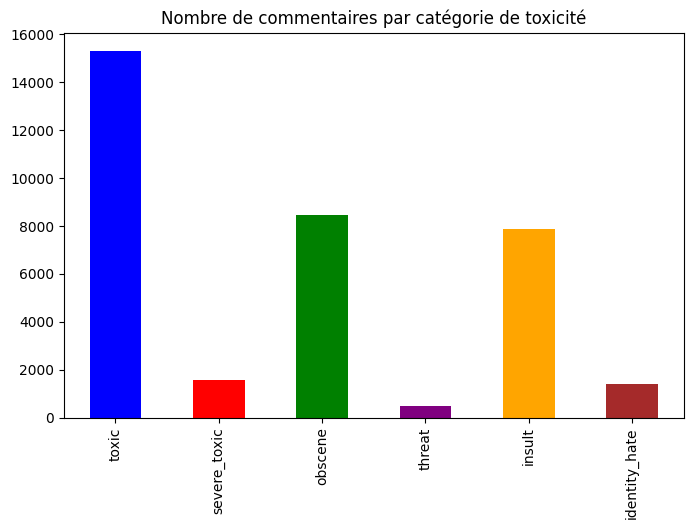

In [ ]:
#reparition des classes par catégorie de toxicité

# Compter les occurrences de chaque classe
label_counts = data.iloc[:, 2:].sum()

# Affichage en barres
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color=['blue', 'red', 'green', 'purple', 'orange', 'brown'])
plt.title("Nombre de commentaires par catégorie de toxicité")
plt.show()


notre jeu de données est constitué de commentaires jugés non toxiques :


In [ ]:
#voir le pourcentage de commentaires jugés non toxiques

clean_comments = (data.iloc[:, 2:].sum(axis=1) == 0).mean()
print(f"Pourcentage de commentaires non toxiques: {clean_comments:.2%}")


Pourcentage de commentaires non toxiques: 89.83%


On affiche des exemples de commentaires pour pouvoir avoir en plus une idée visuel des types d'insultes, menaces, etc...

In [ ]:
#voir des exemples de commentaires (1 toxique et 1 non toxique)

# Exemple d'un commentaire toxique
print(data[data["toxic"] == 1]["comment_text"].sample(5).values)

# Exemple d'un commentaire propre
print(data[(data.iloc[:, 2:].sum(axis=1) == 0)]["comment_text"].sample(5).values)


['i was a homosexual, and i loved to jack off.'
 "Sheodred? Didn't you also accuse these other IPs; 58.7.244.17 , .93.107.209.165 , 109.77.50.2 , 143.239.103.219 of being her/him? lol you poor sad little man 143.239.7.4"
 "==  good grief.  can you read?\n\nwhy don't you try examining the substance of the links?  I am sick and tired of children ranting without reading.  ~~"
 "Rats at the Wikipedia web site \n\nRats are around us everyday. Unfortunately we as good honest citizens have to deal with these idiots everyday and need to know how to kick ass big time man you know for sure for sure. Well here I sit a broken hearted, came to shit, but only farted. That was one of the greatest poems ever!!! Got a 3 hour standing ovation back in 1956 at the convention center in San Antonio God it was good. Some times I think shiting was Gods way of making a joke with mankind you know. Excuse me oh bartender I will take another Jack and coke thanks!!! O.K where were we, oh yes licking me naked. The 

In [ ]:
#vérifier qu'aucune donnée n'est manquante

print(data.isnull().sum())


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


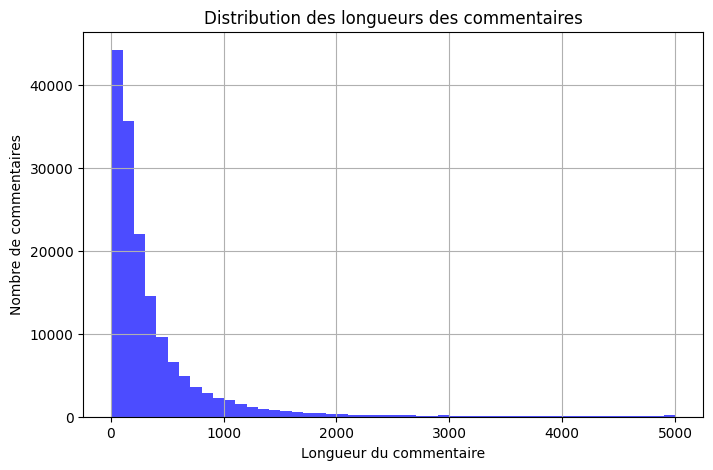

In [ ]:
#analyse des longueurs de commentaires

data["comment_length"] = data["comment_text"].apply(len)

plt.figure(figsize=(8,5))
data["comment_length"].hist(bins=50, color='blue', alpha=0.7)
plt.title("Distribution des longueurs des commentaires")
plt.xlabel("Longueur du commentaire")
plt.ylabel("Nombre de commentaires")
plt.show()


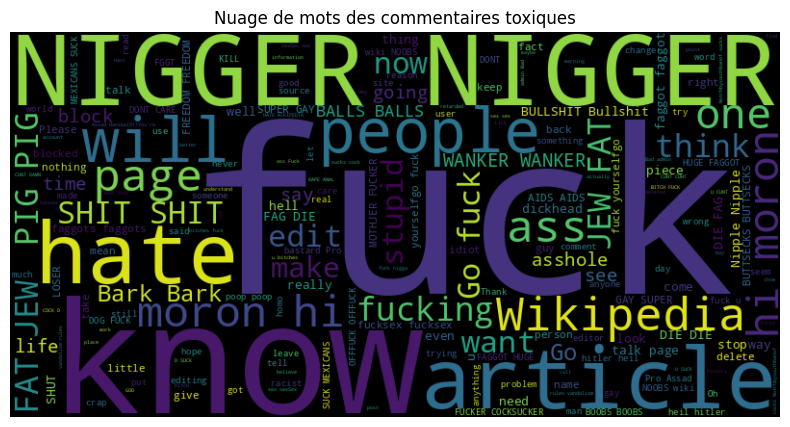

In [ ]:
# Importer la bibliothèque WordCloud pour générer un nuage de mots
from wordcloud import WordCloud

# Filtrer les commentaires toxiques
# Nous sélectionnons les lignes du DataFrame où la colonne "toxic" est égale à 1.
# Ensuite, nous extrayons la colonne "comment_text" qui contient les textes des commentaires.
# On utilise " ".join() pour fusionner tous les commentaires toxiques en un seul texte.
toxic_comments = " ".join(data[data["toxic"] == 1]["comment_text"])

# Générer le nuage de mots
# Nous créons un objet WordCloud et définissons plusieurs paramètres :
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(toxic_comments)

# Afficher le nuage de mots
# Nous utilisons Matplotlib pour afficher l'image du nuage de mots.
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Ajouter un titre
plt.title("Nuage de mots des commentaires toxiques")

# Afficher le graphique
plt.show()


## Préparation des données

Nous avons pu analyser les données et donc voir ce que nous avons dans notre jeu de données.

Nous avons maintenant une colonne contenant des commentaires sous forme de texte brut, et pour pouvoir les utiliser efficacement dans nos analyses, nous devons les nettoyer.

---

**Pourquoi nettoyer le texte ?**

Le nettoyage du texte permet de simplifier les données en éliminant des éléments qui ne sont pas pertinents pour l'analyse. Par exemple, des éléments comme les liens URL, les mentions de profils sur les réseaux sociaux (comme @username), les hashtags (#motcle), ou encore les ponctuations, ne nous aident généralement pas à comprendre le sens du texte. L'objectif est de nous concentrer sur les mots porteurs de sens.

---

**Comment procédons-nous pour nettoyer le texte ?**

On met en minuscules, nous commençons par transformer tout le texte en minuscules. Cela garantit que nous traitons "Bonjour" et "bonjour" de la même manière.

On s'occupe aussi de supprimer les liens, les mentions et les hashtags, ils n'ont pas d'utilités pour ce projet et nous cherchons à nous concentrer sur les commentaires toxiques.

On supprime la ponctuation et les chiffres.

---

**Tokenisation :**

Ensuite, nous divisons le texte en mots, un processus appelé "tokenisation". Cela nous permet de traiter chaque mot individuellement, facilitant ainsi les analyses ultérieures.

Suppression des "stopwords" plus précisement certains mots très fréquents, comme "et", "le", "la", "is", "in", etc., sont retirés car ils n'apportent pas de valeur significative à l'analyse.

In [ ]:
#nettoyage du texte


nltk.download('punkt')
nltk.download('punkt_tab') # Download the punkt_tab data
nltk.download('stopwords')  # Add this line to download stopwords



STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    # Mettre en minuscules
    text = text.lower()
    # Supprimer les liens
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Supprimer les mentions et hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Supprimer les stopwords
    words = [word for word in words if word not in STOPWORDS]
    return " ".join(words)

# Appliquer le nettoyage
data["clean_text"] = data["comment_text"].apply(clean_text)

# Vérifier le résultat
print(data[["comment_text", "clean_text"]].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                          clean_text  
0  explanation edits made username hardcore metal...  
1  daww matches background colour im seemingly st...  
2  hey man im really trying edit war guy constant...  
3  cant make real suggestions improvement wondere...  
4                sir hero chance remember page thats  


**Stemming :**

Cela consiste à réduire un mot à sa racine, en coupant les suffixes. Par exemple, "running" devient "run". Cette méthode est souvent plus rapide mais peut parfois donner des résultats moins précis.


\
**Lemmatisation :**

La lemmatisation est un processus plus sophistiqué qui transforme un mot en son "lemme" (forme canonique) en prenant en compte son sens et sa position grammaticale. Par exemple, "better" sera transformé en "good", et "running" sera réduit à "run" en tant que verbe.

In [ ]:
# Importation des bibliothèques nécessaires pour le traitement du texte
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Télécharger le WordNet pour la lemmatisation (nécessaire à l'utilisation de WordNetLemmatizer)
nltk.download("wordnet")

# Initialisation des outils de prétraitement
# PorterStemmer est utilisé pour effectuer du stemming (réduction des mots à leur racine)
stemmer = PorterStemmer()

# WordNetLemmatizer est utilisé pour effectuer de la lemmatisation (réduction des mots à leur forme canonique)
lemmatizer = WordNetLemmatizer()

# Fonction de prétraitement du texte
def preprocess_text(text):
    # Tokenisation du texte : Divise le texte en une liste de mots (tokens)
    words = word_tokenize(text)

    # Lemmatisation : Chaque mot est transformé en sa forme canonique (par exemple, "running" devient "run")
    # L'objectif est d'obtenir le sens du mot dans son contexte et non seulement la racine du mot
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatisation des mots

    # On rejoint la liste des mots lemmatisés pour obtenir un texte transformé
    return " ".join(words)

# Appliquer la transformation sur chaque texte de la colonne "clean_text" et stocker le résultat dans "processed_text"
# Chaque texte brut dans "clean_text" sera maintenant prétraité (tokenisé, lemmatisé)
data["processed_text"] = data["clean_text"].apply(preprocess_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...


On représenter les mots sous forme de vecteurs numériques, ce qui permet de capturer leurs relations sémantiques. Word2Vec est un modèle d'apprentissage qui génère ces représentations vectorielles.

In [ ]:
# Installer la bibliothèque Gensim pour l'utilisation de Word2Vec
!pip install gensim

# Importation de la classe Word2Vec de Gensim
from gensim.models import Word2Vec

# Tokeniser chaque phrase du corpus en une liste de mots (tokens) pour entraîner le modèle Word2Vec
# "data['processed_text']" contient les textes prétraités (lemmatisés et nettoyés)
# On tokenise chaque texte en une liste de mots
tokenized_sentences = [word_tokenize(text) for text in data["processed_text"]]

# Entraînement du modèle Word2Vec
# Le modèle prend une liste de phrases tokenisées et apprend des vecteurs de mots (word embeddings)
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,  # Les phrases tokenisées à partir du texte prétraité
    vector_size=100,                # Taille du vecteur de chaque mot (représentation numérique de 100 dimensions)
    window=5,                       # Taille de la fenêtre pour les mots contextuels (5 mots autour du mot cible)
    min_count=2,                    # Fréquence minimale des mots pour être inclus dans le modèle (éliminer les mots rares)
    workers=4                       # Nombre de threads à utiliser pour entraîner le modèle en parallèle
)

# Exemple d'utilisation : obtenir la représentation vectorielle du mot "toxic"
# Ici, on affiche le vecteur de caractéristiques pour le mot "toxic"
print(word2vec_model.wv["toxic"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
[-0.04960333 -0.08176162  0.01447298  0.03137325 -0.5771488  -0.31518492
 -0.03690102  0.67713    -0.32749218  0.05032349 -0.18963282 -0.6312262
 -0.06119807  0.20726624 -0.5719975  -0.38103577 -0.08964587 -0.17186698
  0.15880066 -0.5044816   0.4445979   0.18873368 -0.00169178 -0.35068482
 -0.05784821  0.38651574 -0.21880698 -0.42052925 -0.5511716  -0.035243
  0.24811918  0.16409731  0.29778165 -0.22588266 -0.2417381   0.35111177
  0.17202085 -0.27371672 -0.21678019 -0.4382432   0.299318   -0.10152613
  0.11211048 -0.18233609  0.06888989  0.01345783  0.0894953   0.00176201
 -0.10747328  0.12706134  0.12

Comme les commentaires "toxiques" sont beaucoup plus fréquentes que d'autres. Cela peut biaiser les modèles d'apprentissage automatique. Pour corriger cela, nous utilisons les poids de classe.

In [ ]:
#gestion des desequilibre des classes


labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Get unique classes from the target variable
unique_classes = np.unique(data[labels].values) # Get unique classes from all target columns

# Calculer les poids des classes
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=data[labels].values.ravel())
print(class_weights)

[ 0.51902685 13.63932418]


## Entraînement du modèle baseline

Nous allons utiliser 2 techniques, la première sera du random forest et pour la deuxième nous utiliserons BERT de Google.


\
###**Pourquoi tester deux modèles différents ?**

\
**1. Évaluer les performances des approches classiques vs. modernes**

\
**Random Forest** est un modèle traditionnel basé sur des arbres de décision. Il fonctionne bien avec des features extraites manuellement (TF-IDF, CountVectorizer, embeddings).

**BERT**, un modèle de Deep Learning basé sur des Transformers, comprend mieux le contexte et les relations entre les mots.

\
**2. Analyser les avantages et inconvénients de chaque approche**

\
**Random Forest :**

✅ Facile à entraîner et rapide à exécuter

✅ Fonctionne bien sur des petits datasets et avec peu de ressources

❌ Ne capture pas bien le contexte sémantique des phrases

❌ Dépend fortement des features extraites

\
**BERT :**

✅ Comprend mieux le sens des phrases et les nuances du langage

✅ Meilleure précision sur les textes complexes et ambigus

❌ Très gourmand en ressources (GPU requis pour un entraînement efficace)

❌ Entraînement et inférence plus longs

##Random Forest

Ici, nous allons utiliser **50 % des données** pour entraîner notre modèle, ce qui permet de réduire le temps de calcul tout en conservant une quantité suffisante d’informations pour l’apprentissage. Pour optimiser le processus, nous mettons en place une **pipeline**, qui automatisera l’ensemble du traitement des données, de la vectorisation du texte à l’entraînement du modèle. Cela garantira une meilleure efficacité, une reproductibilité optimale et une exécution simplifiée pour les futures prédictions.

In [ ]:
# Random Forest

# Random Forest avec Pipeline

# Charger les données (on suppose que 'data' est déjà défini)
# On prend un échantillon aléatoire de 50% des données pour travailler sur un sous-ensemble
sample_df = data.sample(frac=0.5, random_state=42)

# Définition des features (X) et des labels (y)
# Les textes prétraités sont dans la colonne 'processed_text', et les étiquettes de toxicité sont dans les colonnes correspondantes
X = sample_df["processed_text"]  # Texte d'entrée
y = sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]  # Étiquettes de sortie (toxiques ou non)

# Split train/test
# Diviser les données en un ensemble d'entraînement et un ensemble de test
# 80% des données seront utilisées pour l'entraînement et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création de la pipeline
# La pipeline est composée de deux étapes :
# 1. Vectorisation des textes en utilisant la méthode TF-IDF (Term Frequency - Inverse Document Frequency)
#    Cette étape convertit le texte brut en une représentation numérique qui peut être utilisée par le modèle.
#    'max_features=5000' limite le nombre de caractéristiques à 5000 mots les plus fréquents.
# 2. Application d'un classifieur Random Forest en sortie multiple (MultiOutputClassifier) pour chaque type de toxicité.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Étape 1 : Vectorisation des textes avec TF-IDF
    ('rf', MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42)))  # Étape 2 : Modèle Random Forest multi-label
])

# Entraînement de la pipeline
# Le modèle est entraîné sur les données d'entraînement (X_train et y_train)
pipeline.fit(X_train, y_train)  # La pipeline apprend à partir des données d'entraînement

# Prédictions
# Prédire les étiquettes de toxicité pour les données de test (X_test)
y_pred = pipeline.predict(X_test)  # y_pred contient les prédictions pour chaque label

# Évaluation
# L'évaluation est effectuée à l'aide du rapport de classification
# Le rapport de classification donne des métriques pour chaque label, comme la précision, le rappel et le score F1
# 'target_names' fournit les noms des classes, ici les types de toxicité
print(classification_report(y_test, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]))

# Sauvegarde de la pipeline
# Après l'entraînement, la pipeline est sauvegardée dans un fichier pour une utilisation future.
# Joblib est utilisé pour sauvegarder l'objet Python complet.
import joblib
joblib.dump(pipeline, "rf_toxicity_pipeline.pkl")  # Sauvegarde de la pipeline dans un fichier
print("Pipeline sauvegardée !")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

        toxic       0.83      0.63      0.72      1521
 severe_toxic       0.45      0.06      0.10       163
      obscene       0.85      0.74      0.79       829
       threat       0.50      0.04      0.08        49
       insult       0.75      0.59      0.66       793
identity_hate       0.80      0.13      0.23       150

    micro avg       0.81      0.59      0.69      3505
    macro avg       0.70      0.37      0.43      3505
 weighted avg       0.79      0.59      0.66      3505
  samples avg       0.06      0.05      0.05      3505

Pipeline sauvegardée !


Nous allons utiliser **les matrices de confusion** afin d'évaluer les performances de notre modèle. Elles permettent de :

* Comprendre où le modèle se trompe, en montrant les faux positifs (commentaires non toxiques prédits comme toxiques) et les faux négatifs (commentaires toxiques non détectés).

* Analyser la précision et le rappel pour chaque catégorie de toxicité, afin d’identifier si le modèle privilégie certaines classes au détriment d’autres.

* Aider à l’ajustement du modèle, en détectant d’éventuels déséquilibres et en optimisant les paramètres pour améliorer la classification.

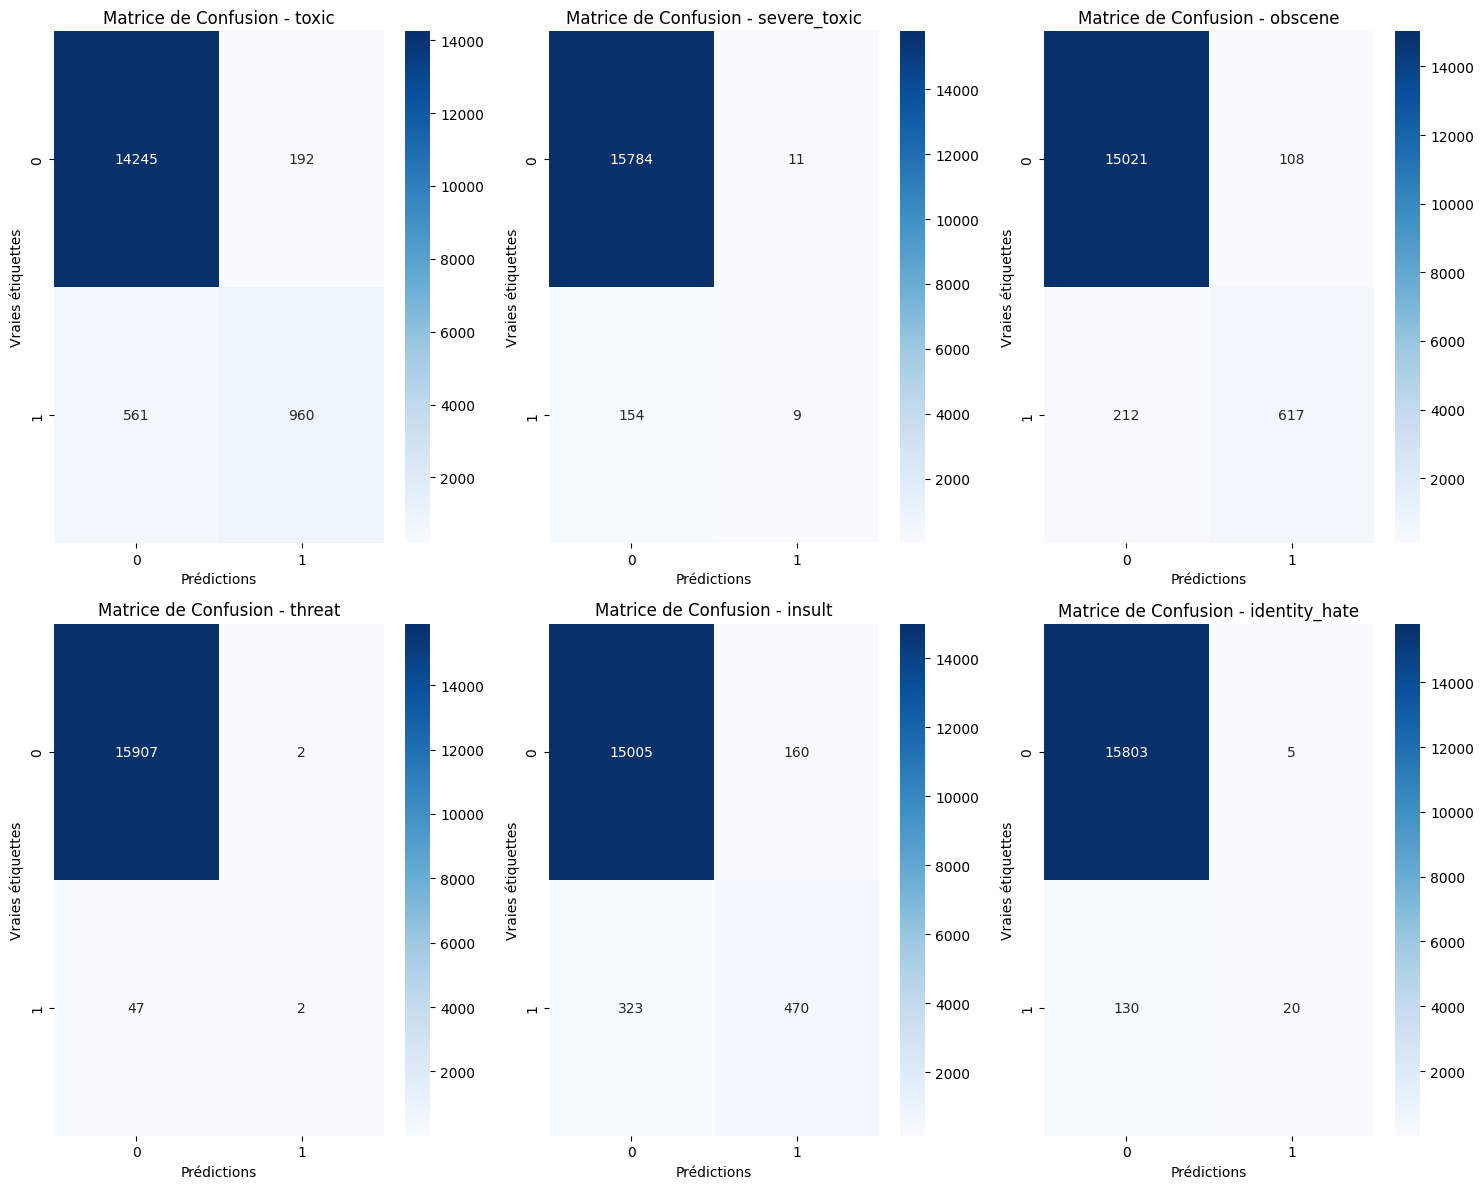

In [ ]:
# Prédictions
# Effectuer des prédictions sur les données de test X_test en utilisant la pipeline chargée (modèle pré-entraîné)
y_pred = pipeline.predict(X_test)  # y_pred contient les prédictions pour chaque étiquette de toxicité

# Liste des labels de toxicité
# Ces labels correspondent aux types de toxicité que le modèle doit prédire : "toxic", "severe_toxic", etc.
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Initialisation de la figure pour la visualisation des matrices de confusion
# On crée une figure de taille (15, 12) pour avoir une vue d'ensemble claire
plt.figure(figsize=(15, 12))

# Itérer sur chaque label pour générer et afficher la matrice de confusion
# On parcourt la liste des labels, et pour chaque label, une matrice de confusion est calculée et affichée
for i, label in enumerate(labels):
    # Créer une sous-figure (subplot) pour chaque matrice de confusion (2 lignes, 3 colonnes)
    plt.subplot(2, 3, i+1)

    # Calcul de la matrice de confusion pour chaque étiquette
    # La matrice de confusion est générée en comparant les vraies étiquettes (y_test[label]) avec les prédictions (y_pred[:, i])
    # y_pred[:, i] sélectionne la colonne correspondant à l'étiquette i
    cm = confusion_matrix(y_test[label], y_pred[:, i])  # Matrice de confusion

    # Visualisation de la matrice de confusion avec Seaborn
    # 'annot=True' ajoute les valeurs sur la matrice, 'fmt='d'' formate les valeurs comme des entiers
    # 'cmap' définit la palette de couleurs, ici "Blues" pour une échelle de couleurs bleues
    # xticklabels et yticklabels montrent les étiquettes des axes comme "0" et "1"
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])

    # Ajouter le titre de chaque matrice de confusion, basé sur le label actuel
    plt.title(f'Matrice de Confusion - {label}')
    # Ajouter les labels pour les axes X et Y
    plt.xlabel('Prédictions')  # Axe des prédictions (0 ou 1)
    plt.ylabel('Vraies étiquettes')  # Axe des vraies étiquettes (0 ou 1)

# Ajuster la disposition des sous-figures pour éviter tout chevauchement
plt.tight_layout()

# Afficher la figure avec toutes les matrices de confusion
plt.show()



Pour tester l'entraînement de notre modèle, on permet à l'utilisateur de tester plusieurs textes en interaction directe. Il analyse chaque texte et renvoie des prédictions sur six catégories de toxicité spécifiques : "toxique", "très toxique", "obscène", "menace", "insulte" et "haine liée à l'identité".

In [ ]:
# Fonction de prédiction pour évaluer la toxicité d'un texte
def predict_toxicity(text):
    # Charger la pipeline d'entraînement précédemment sauvegardée
    # La pipeline est un modèle pré-entrainé, ici un modèle Random Forest, qui a été sauvegardé dans un fichier .pkl
    pipeline = joblib.load("rf_toxicity_pipeline.pkl")  # Chargement du modèle avec joblib

    # Effectuer la prédiction directement sur le texte brut
    # Le modèle attend une liste en entrée, donc le texte est mis dans une liste avant d'être passé à la fonction predict
    # La fonction predict retourne un tableau avec les résultats pour chaque label de toxicité
    prediction = pipeline.predict([text])[0]  # On prend le premier élément du résultat car predict retourne une liste

    # Liste des labels représentant les différentes catégories de toxicité
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

    # Conversion des résultats de la prédiction en dictionnaire
    # Chaque étiquette est associée à un score de prédiction. Le score est transformé en entier (0 ou 1)
    results = {label: int(pred) for label, pred in zip(labels, prediction)}

    # Retourner les résultats sous forme de dictionnaire
    return results

# Test interactif pour prédire la toxicité de plusieurs messages
while True:
    # Demander à l'utilisateur de saisir un message
    user_text = input("Entrez un message (ou 'exit' pour quitter) : ")

    # Si l'utilisateur entre 'exit', on sort de la boucle et on arrête le programme
    if user_text.lower() == "exit":
        break  # Sortir de la boucle

    # Afficher la prédiction de toxicité pour le texte saisi par l'utilisateur
    # La fonction predict_toxicity retourne un dictionnaire avec les prédictions
    prediction = predict_toxicity(user_text)

    # Affichage des résultats sous forme lisible
    print("\nPrédiction :", prediction)

Entrez un message (ou 'exit' pour quitter) : love ya nigga

Prédiction : {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 1, 'identity_hate': 1}
Entrez un message (ou 'exit' pour quitter) : fuck off

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : love you all

Prédiction : {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : exit


## Premier modèle BERT (LSTM)

Maintenant, nous allons passer au premier modèle BERT. Nous allons entraîner un modèle LSTM sur 50% des données pour prédire la toxicité des textes. Le processus commence par la préparation des données : nous sélectionnerons un échantillon de 50% des textes, que nous transformerons en séquences numériques et compléterons avec du padding pour assurer une longueur uniforme. Ensuite, nous construirons un modèle LSTM bidirectionnel pour analyser les dépendances contextuelles et prédire six catégories de toxicité. Après l'entraînement, nous sauvegarderons le modèle et le tokenizer pour les utiliser afin de prédire la toxicité de nouveaux textes.



In [ ]:
# Charger un échantillon aléatoire de 50% des données disponibles
sample_df = data.sample(frac=0.5, random_state=42)  # 'frac=0.5' prend 50% des données
X = sample_df["processed_text"].values  # Texte pré-traité (entrée)
y = sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values  # Labels de toxicité (sortie)

# Paramètres du modèle
MAX_VOCAB_SIZE = 20000  # Taille maximale du vocabulaire
MAX_SEQUENCE_LENGTH = 100  # Longueur maximale des séquences (en nombre de mots)
EMBEDDING_DIM = 100  # Dimension des vecteurs d'embedding (représentation des mots)

# Tokenization et transformation des textes en séquences numériques
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")  # Initialisation du tokenizer avec un vocabulaire limité à 20 000 mots
tokenizer.fit_on_texts(X)  # Apprentissage du vocabulaire à partir des textes
X_sequences = tokenizer.texts_to_sequences(X)  # Conversion des textes en séquences d'indices de mots
X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")  # Ajout de padding pour uniformiser la longueur des séquences

# Division des données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Construction du modèle LSTM (Long Short-Term Memory) pour la classification de texte
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),  # Couche d'embedding pour représenter les mots
    Bidirectional(LSTM(128, return_sequences=True)),  # LSTM bidirectionnel avec 128 unités et sortie séquencée
    Dropout(0.3),  # Dropout pour éviter le surapprentissage (30% des neurones seront "désactivés" aléatoirement)
    Bidirectional(LSTM(64)),  # Autre couche LSTM bidirectionnelle avec 64 unités
    Dropout(0.3),  # Autre couche de Dropout pour la régularisation
    Dense(32, activation='relu'),  # Couche dense avec 32 neurones et activation ReLU
    Dense(6, activation='sigmoid')  # Couche de sortie avec 6 neurones (un pour chaque classe de toxicité), activation sigmoïde pour la classification multi-label
])

# Compilation du modèle avec l'optimiseur Adam, la fonction de perte binaire (car il s'agit d'un problème multi-label) et la métrique d'exactitude
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle sur les données d'entraînement, avec validation sur l'ensemble de test
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Sauvegarde du modèle et du tokenizer
model.save("lstm_toxicity_model.keras")  # Sauvegarde du modèle au format natif Keras (recommandé)

# Sauvegarde du tokenizer pour pouvoir l'utiliser lors des prédictions futures
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Message de confirmation
print("Modèle et tokenizer sauvegardés !")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1995/1995 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - accuracy: 0.8190 - loss: 0.1185 - val_accuracy: 0.9932 - val_loss: 0.0554
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 70s 25ms/step - accuracy: 0.9944 - loss: 0.0500 - val_accuracy: 0.9932 - val_loss: 0.0538
Epoch 3/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.9943 - loss: 0.0445 - val_accuracy: 0.9932 - val_loss: 0.0547
Epoch 4/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 89s 29ms/step - accuracy: 0.9937 - loss: 0.0395 - val_accuracy: 0.9928 - val_loss: 0.0557
Epoch 5/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.9934 - loss: 0.0349 - val_accuracy: 0.9922 - val_loss: 0.0589
Modèle et tokenizer sauvegardés !


Pour tester l'entraînement de notre modèle, on permet à l'utilisateur de tester plusieurs textes en interaction directe. Il analyse chaque texte et renvoie des prédictions sur six catégories de toxicité spécifiques : "toxique", "très toxique", "obscène", "menace", "insulte" et "haine liée à l'identité".

In [ ]:
# Fonction de prédiction pour déterminer la toxicité d'un texte
def predict_toxicity(text):
    # Charger le modèle préalablement entraîné et sauvegardé
    model = tf.keras.models.load_model("lstm_toxicity_model.keras")  # Chargement du modèle LSTM depuis le fichier

    # Charger le tokenizer utilisé lors de l'entraînement
    with open("tokenizer.pkl", "rb") as f:  # Ouvrir le fichier du tokenizer
        tokenizer = pickle.load(f)  # Charger le tokenizer à partir du fichier

    # Tokenization et padding du texte d'entrée
    sequence = tokenizer.texts_to_sequences([text])  # Transformer le texte brut en une séquence d'indices de mots
    # Appliquer un padding pour uniformiser la longueur des séquences (en tronquant ou ajoutant des zéros)
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

    # Effectuer la prédiction avec le modèle sur la séquence padée
    prediction = model.predict(padded_sequence)[0]  # La méthode 'predict' renvoie un tableau de prédictions ; on prend la première prédiction
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]  # Les labels des classes à prédire
    # Associer chaque prédiction à son label respectif et les convertir en float pour faciliter l'affichage
    results = {label: float(pred) for label, pred in zip(labels, prediction)}

    return results  # Retourner le dictionnaire des résultats

# Test interactif pour tester la prédiction sur plusieurs textes
while True:
    user_text = input("Entrez un message (ou 'exit' pour quitter) : ")  # Demander à l'utilisateur de saisir un texte
    if user_text.lower() == "exit":  # Si l'utilisateur tape 'exit', on sort de la boucle
        break  # Sortir de la boucle
    prediction = predict_toxicity(user_text)  # Appeler la fonction de prédiction avec le texte de l'utilisateur
    print("\nPrédiction :", prediction)  # Afficher les résultats de la prédiction


Entrez un message (ou 'exit' pour quitter) : hi all
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step

Prédiction : {'toxic': 0.052008677273988724, 'severe_toxic': 0.00023552333004772663, 'obscene': 0.00712371151894331, 'threat': 0.0007081617950461805, 'insult': 0.007326606195420027, 'identity_hate': 0.0014778133481740952}
Entrez un message (ou 'exit' pour quitter) : fuck off
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step

Prédiction : {'toxic': 0.997027575969696, 'severe_toxic': 0.24149338901042938, 'obscene': 0.9898640513420105, 'threat': 0.012251894921064377, 'insult': 0.7411269545555115, 'identity_hate': 0.03673814237117767}
Entrez un message (ou 'exit' pour quitter) : exit


## Deuxième modèle BERT (DistilBERT)

Nous avons maintenant un deuxième modèle plus précis, basé sur **BERT (DistilBERT)**, mais il nécessite un temps **d'entraînement beaucoup plus long**. Ce modèle est plus puissant car il utilise une version allégée de BERT, le DistilBERT, qui est pré-entraîné pour mieux comprendre le contexte du texte et les relations entre les mots.

Ce qui change par rapport au modèle LSTM, c'est l’utilisation du modèle pré-entraîné **DistilBERT** pour extraire les représentations contextuelles des textes, plutôt que d'apprendre des représentations de séquences directement à partir des données. L'entraînement prend plus de temps, car nous devons **ajuster un modèle complexe**, tout en utilisant un grand nombre de paramètres et un **plus grand volume de données**.

\
Le processus commence par la **tokenisation** des textes avec le tokenizer de DistilBERT, qui transforme chaque mot en une représentation numérique plus riche. Ensuite, nous utilisons ces représentations avec un modèle de réseau de neurones basé sur BERT, et nous ajoutons des couches supplémentaires pour effectuer la **classification multi-label** sur les six types de toxicité.

Ce modèle, plus précis et plus sophistiqué, permet de mieux capturer les **subtilités du langage** et d’améliorer les performances des prédictions de toxicité. Cependant, il nécessite **plus de ressources et de temps pour l'entraînement**. Une fois l’entraînement terminé, le modèle et le tokenizer sont sauvegardés pour pouvoir être utilisés pour des prédictions futures.



In [ ]:
# On commence par prendre un échantillon de 50% des données pour travailler sur un sous-ensemble
# Ce sous-échantillon est pris aléatoirement pour s'assurer que les données sont représentatives
sample_df = data.sample(frac=0.5, random_state=42)

# X contient les textes prétraités (les colonnes avec les textes)
# y contient les étiquettes de toxicité sous forme de labels multi-classes (toxic, severe_toxic, etc.)
X = sample_df["processed_text"].values
y = sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

# Initialiser le tokenizer BERT (DistilBERT ici, une version plus légère de BERT)
# Le tokenizer permet de convertir les textes en séquences de tokens que le modèle peut comprendre
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Fonction pour tokeniser les textes et les transformer en tenseurs compatibles avec BERT
def encode_texts(texts, tokenizer, max_len=128):
    # On utilise la méthode tokenizer pour encoder les textes en une séquence de tokens
    return tokenizer(texts.tolist(), truncation=True, padding='max_length', max_length=max_len, return_tensors='tf')

# Tokenisation des textes à l'aide du tokenizer BERT
encoded_texts = encode_texts(X, tokenizer)
input_ids = encoded_texts['input_ids']  # Récupération des IDs des tokens
attention_masks = encoded_texts['attention_mask']  # Masque d'attention (indique quelles parties de la séquence sont réelles)

# Séparation des données en ensembles d'entraînement et de test
# Nous utilisons un test_size de 0.2, donc 80% des données seront utilisées pour l'entraînement et 20% pour le test
X_train, X_test, mask_train, mask_test, y_train, y_test = train_test_split(
    input_ids.numpy(), attention_masks.numpy(), y, test_size=0.2, random_state=42
)

# Définir une couche personnalisée pour encapsuler le modèle DistilBERT
# Cette couche nous permet de charger DistilBERT et de l'utiliser directement dans notre modèle Keras
class TFDistilBertLayer(Layer):
    def __init__(self, trainable=False, **kwargs):
        super(TFDistilBertLayer, self).__init__(**kwargs)
        self.trainable = trainable  # Le modèle DistilBERT est par défaut non entraînable
        self.bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
        self.bert_model.trainable = self.trainable  # On peut choisir si on veut entraîner les poids de DistilBERT

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs  # Les entrées du modèle : input_ids et attention_mask
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)  # Passage des inputs dans DistilBERT
        return outputs[0][:, 0, :]  # On retourne le vecteur de représentation associé au token [CLS] (représentation globale)

    def get_config(self):
        config = super(TFDistilBertLayer, self).get_config()
        config.update({"trainable": self.trainable})
        return config

# Définition des entrées pour le modèle Keras
# Nous définissons les deux entrées principales : input_ids et attention_mask
input_ids_layer = Input(shape=(128,), dtype=tf.int32, name="input_ids")  # Taille des séquences = 128
attention_mask_layer = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Charger le modèle pré-entraîné DistilBERT et l'utiliser dans notre modèle Keras
bert_output = TFDistilBertLayer(trainable=False)([input_ids_layer, attention_mask_layer])

# Ajouter des couches supplémentaires pour le traitement des sorties du modèle BERT
# - Une couche dense avec une activation ReLU pour introduire de la non-linéarité
# - Une couche Dropout pour éviter le sur-apprentissage (dropout à 30%)
# - Une couche de sortie avec 6 neurones (une sortie par étiquette de toxicité), activée par sigmoïde pour la classification multi-label
dense = Dense(128, activation='relu')(bert_output)
dropout = Dropout(0.3)(dense)
output = Dense(6, activation='sigmoid')(dropout)  # Sortie sigmoïde pour chaque type de toxicité

# Création du modèle Keras en spécifiant les entrées et sorties
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

# Compilation du modèle
# Nous utilisons l'optimiseur Adam avec un taux d'apprentissage très faible (2e-5) pour éviter un entraînement trop rapide
# La fonction de perte est la binary_crossentropy, car il s'agit d'un problème de classification multi-label
optimizer = Adam(learning_rate=2e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entraînement du modèle
# Nous spécifions le nombre d'époques (4) et la taille des lots (16)
# La validation est effectuée sur l'ensemble de test pour surveiller la performance du modèle pendant l'entraînement
epochs = 4
batch_size = 16
model.fit(
    [X_train, mask_train], y_train,  # Entrées : input_ids et attention_mask
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_test, mask_test], y_test)  # Validation sur l'ensemble de test
)

# Prédictions avec un seuil ajusté
# Les sorties de chaque neurone sont comprises entre 0 et 1. Nous appliquons un seuil de 0.3 pour considérer une prédiction comme positive
# Cela signifie que pour chaque type de toxicité, une prédiction est positive si elle dépasse 0.3
y_pred = (model.predict([X_test, mask_test]) > 0.3).astype(int)

# Affichage du rapport de classification
# Ce rapport fournit des métriques comme la précision, le rappel, et le F1-score pour chaque label
print(classification_report(y_test, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], zero_division=0))

# Sauvegarde du modèle et du tokenizer pour une utilisation future
# Sauvegarde du modèle Keras au format natif
model.save("bert_toxicity_model.keras")
# Sauvegarde du tokenizer pour pouvoir l'utiliser plus tard lors des prédictions
joblib.dump(tokenizer, "bert_tokenizer.pkl")
print("Modèle et tokenizer sauvegardés !")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/4
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 323s 79ms/step - accuracy: 0.4764 - loss: 0.2945 - val_accuracy: 0.9922 - val_loss: 0.0959
Epoch 2/4
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 286s 70ms/step - accuracy: 0.6167 - loss: 0.0994 - val_accuracy: 0.9924 - val_loss: 0.0790
Epoch 3/4
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 347s 77ms/step - accuracy: 0.7340 - loss: 0.0840 - val_accuracy: 0.9919 - val_loss: 0.0745
Epoch 4/4
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 304s 76ms/step - accuracy: 0.7883 - loss: 0.0782 - val_accuracy: 0.9929 - val_loss: 0.0723
499/499 ━━━━━━━━━━━━━━━━━━━━ 67s 130ms/step
               precision    recall  f1-score   support

        toxic       0.68      0.64      0.66      1521
 severe_toxic       0.39      0.38      0.39       163
      obscene       0.66      0.59      0.63       829
       threat       0.00      0.00      0.00        49
       insult       0.60      0.56      0.58       793
identity_hate       0.46      0.21      0.28       150

    micro avg       0.64      0.57      0

Comme pour les 2 modèles précédents, pour tester l'entraînement de notre modèle, on permet à l'utilisateur de tester plusieurs textes en interaction directe. Il analyse chaque texte et renvoie des prédictions sur six catégories de toxicité spécifiques : "toxique", "très toxique", "obscène", "menace", "insulte" et "haine liée à l'identité".

In [ ]:
# Fonction de prédiction pour déterminer la toxicité d'un texte
def predict_toxicity(text):
    # Charger le tokenizer BERT préalablement sauvegardé
    tokenizer = joblib.load("bert_tokenizer.pkl")  # Charger le tokenizer depuis le fichier .pkl

    # Charger le modèle BERT préalablement entraîné et sauvegardé
    # Le modèle BERT est chargé avec une couche personnalisée (TFDistilBertLayer)
    model = tf.keras.models.load_model("bert_toxicity_model.keras", custom_objects={'TFDistilBertLayer': TFDistilBertLayer})

    # Encodage du texte d'entrée avec le tokenizer BERT
    # La fonction encode_texts prépare le texte pour le modèle BERT en le transformant en 'input_ids' et 'attention_mask'
    encoded = encode_texts(np.array([text]), tokenizer)
    input_ids, attention_mask = encoded['input_ids'], encoded['attention_mask']  # Récupérer les 'input_ids' et 'attention_mask'

    # Effectuer la prédiction avec le modèle sur les 'input_ids' et 'attention_mask'
    # Le seuil de 0.3 est utilisé pour décider si un label est activé (1) ou non (0)
    prediction = (model.predict([input_ids, attention_mask]) > 0.3).astype(int)[0]  # Conversion de la prédiction en valeurs binaires

    # Liste des labels de toxicité pour chaque prédiction
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

    # Retourner un dictionnaire associant chaque label à sa prédiction (0 ou 1)
    # Les prédictions sont converties en entiers pour un affichage plus clair
    return {label: int(pred) for label, pred in zip(labels, prediction)}

# Test interactif pour prédire la toxicité de plusieurs messages
while True:
    # Demander à l'utilisateur de saisir un message
    user_text = input("Entrez un message (ou 'exit' pour quitter) : ")

    # Si l'utilisateur entre 'exit', on sort de la boucle et on arrête le programme
    if user_text.lower() == "exit":
        break  # Sortir de la boucle

    # Afficher la prédiction de toxicité pour le texte saisi par l'utilisateur
    print("\nPrédiction :", predict_toxicity(user_text))

Entrez un message (ou 'exit' pour quitter) : love you nigga


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : fuck off


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : love you all guys


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Prédiction : {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : exit
